<a href="https://colab.research.google.com/github/brendanpatalong/M2R/blob/main/icis_systmatic_trading_backtesting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install yfinance

In [ ]:
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import yfinance as yf
import matplotlib.pyplot as plt
import datetime

In [ ]:
class Strategies():
  """
  A class that contains code that strategies later on will inherit from.
  params:
  -----
  codes = list of stock short codes
  -----
  """
  def __init__(self, codes):
    self.codes = codes

  def import_data(self, start_date, end_date):
    """downloads all data for each backtest from yahoo Finance."""
    self.data = yf.download(self.codes, start_date, end_date)
    # if only one stock code is entered data is reformated so that
    # it is the same format as when multiple stocks are entered
    if len(self.codes) == 1:
      self.data.columns = [self.data.columns, self.codes*len(self.data.columns)]
    #returns data where any row containing NAN values is removed
    return self.data.dropna()

  def backtest(self, start_date, end_date):
    """
    Returns a list with elements of a time series' from yahoo finance as well as
    an array of values between -1 and 1 that represent the strategy over the giv
    en period with 1 representing a long postion in one stock, 0 representing a
    neutral postion and -1 representing a short position.
    params:
    -----
    start_date, end_date  = string of dates for backtesting with format Y-m-d
    -----
    """
    # sets up a dataframe to contain all strategy info for each stock at each 
    # time index
    self.data = self.import_data(start_date, end_date)
    self.strat = pd.DataFrame(columns = self.codes, index = self.data.index)
  
  def evaluate(self, start_date, end_date, fig=True, risk_free_rate=0.01,
               **kwargs):
    """
    returns a dataframe with columns icluding the daily returns of the portfolio,
    the cumulative returns, the sharp ratio and all relevant plots of both the 
    stock price of each stock 
    and the strategy.
    params:
    ----
    start_date, end_date  = string of dates for backtesting with format Y-m-d
    fig = boolean variable that can be used to produce figures
    risk_free_rate = average rate of return on a very safe government issued bond
                     used to calculate the sharpe ratio with
    **kwargs are any specific keyword arguments that can be passed to the
    backtesting function to allow for comparison of the backtest for different
    possible parameters defined in the subclass.
    ----
    """
    # run the backtest function and define the stock price data to be once again
    # self.data and the signals self.strat
    self.risk_free_rate = risk_free_rate
    self.data = self.import_data(start_date, end_date)
    self.strat = self.backtest(start_date, end_date, **kwargs)
    # sets up a new dataframe which will give the returns of the portfolio
    self.return_df = pd.DataFrame(columns= ["daily returns", "cumulative returns"],
                                  index = self.data.index)
    # sets tyhe return on day 1 to be 0
    self.return_df["daily returns"][0] = 0
    # loops through the remaining dates and calculates the return across 
    # the portfolio
    for i in range(1, len(self.data)):
      self.return_df["daily returns"][i] = sum(100*self.strat[c][i-1]*(self.data["Adj Close"][c][i] - self.data["Adj Close"][c][i-1]) 
                                               /self.data["Adj Close"][c][i-1] for c in self.codes)

    # calculates the cumulative return for each date
    self.return_df["cumulative returns"] = ((self.return_df["daily returns"]/100+1).cumprod()-1)*100
    if fig:
      plt.figure()
      plt.title("Strategy Backtest from "+ start_date+" to "+end_date)
      plt.plot(self.return_df["cumulative returns"])
      plt.show()
      for c in self.codes:
        plt.figure()
        plt.title("buy and hold from "+ start_date+" to "+end_date+" for "+str(c))
        plt.plot(self.data["Adj Close"][c])
        plt.show()

    # calcualtes the sharpe ratio for the given risk free rate of return 
    sharpe = ((self.return_df["cumulative returns"][len(self.return_df)-1]/100-self.risk_free_rate)
                /self.return_df["daily returns"].std())

    return [self.return_df, sharpe]


In [ ]:
class StrategyZero(Strategies):
  """
  A basic strategy that buys when stock price is below its previous a point
  low and sells when stock price is above its previous a point high.
  """

  def backtest(self, start_date, end_date, t=4, **kwargs):
    """
    returns a backtest for strategy1
    """
    # import codes from the parent class
    Strategies.backtest(self, start_date, end_date)
    self.t = t
    # loop through each of the stock codes and for each code sets up an array 
    # of stock price signals and moving averages for each time value.
    for c in self.codes:
      self.signals = np.zeros(len(self.data))
      self.mah, self.mal = np.zeros(len(self.data)), np.zeros(len(self.data))
    
    # loop through the time values and calculate the 7-point average of both
    # the high and low price values.
      for i in range(len(self.data)):
        if i > self.t:
          self.mah[i] = self.data["High"][c][i-self.t-1:i-1].mean()
          self.mal[i] = self.data["Low"][c][i-self.t-1:i-1].mean()
          # if the close price is less than the average of the previous a point low buy.
          if self.data["Close"][c][i] < self.mal[i]:
            self.signals[i] = 1
          # if the close price is more than the average of the previous a point high sell.
          elif self.data["Close"][c][i] > self.mah[i]:
            self.signals[i] = 0
          else:
            self.signals[i] = self.signals[i-1]

      # add each of the stock price signals to the signal dataframe defined in
      # the parent class
      self.strat[c] = self.signals
      # divding through by len(self.codes) gives an equal weighting to each asset
    return self.strat/len(self.codes)


In [ ]:
class StrategyInsertTeamNumber(Strategies):
  pass


[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed


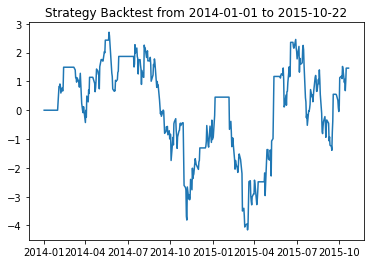

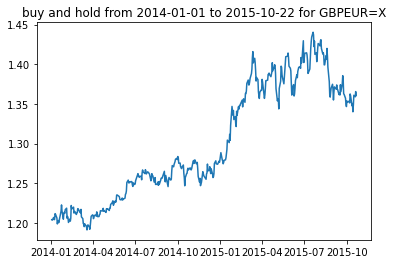

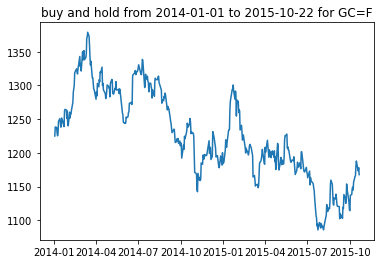

[           daily returns cumulative returns
Date                                       
2014-01-02             0                  0
2014-01-03             0                  0
2014-01-06             0                  0
2014-01-07             0                  0
2014-01-08             0                  0
...                  ...                ...
2015-10-15      0.324627            1.00577
2015-10-16      0.450431            1.46073
2015-10-19             0            1.46073
2015-10-20             0            1.46073
2015-10-21             0            1.46073

[452 rows x 2 columns], 0.013107167185554405]


In [ ]:
# testing
test1 = StrategyZero(["GBPEUR=X","GC=F"])
print(test1.evaluate("2014-01-01", "2015-10-22", fig=True, t=15, risk_free_rate=0.01))